In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import echo_utils
from seaborn import despine
# # plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
# figure = {'figsize' : (16,8)}

# matplotlib.rc('font', **font)
# matplotlib.rc('figure', **figure)


# Single-trial Fits

### outlier detection by merging all (valid) channels & subjects

In [385]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data
with open(result_path + "all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open(result_path + "all_offset.txt", "rb") as fp: # unpickling
    all_offset = pickle.load(fp)
with open(result_path + "all_knee.txt", "rb") as fp: # unpickling
    all_knee = pickle.load(fp)
with open(result_path + "all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)

# collect all trials into df
col_names = ['patient', 'cond', 'trial', 'chan', 'offset', 'exp', 'knee', 'tau']
df_alltrials = pd.DataFrame(columns=col_names)

# s3 has really bad data, s15 & s17 are same as s5 & s8
patient_id = range(1,18) # patients go from s1-s17, but use only a subset
patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,15]


for i_p in patient_inds:
    patient_mat = patient_id[i_p]*np.ones_like(all_offset[i_p])
    nchans, ntrials = all_offset[i_p][0].shape
    # make channel metadata matrices
    cond_mat = np.ones_like(all_offset[i_p])*np.array([0,1,2])[:,None,None]
    trial_mat = np.repeat(np.outer(np.ones((nchans,1)), np.arange(ntrials)[None,:])[None,:,:], 3, axis=0)
    chan_mat = np.repeat(np.outer(np.ones((ntrials,1)), np.arange(nchans)[None,:]).T[None,:,:], 3, axis=0)
    
    ft_agg = [patient_mat.flatten(), cond_mat.flatten(), trial_mat.flatten(), chan_mat.flatten()]
    for ft in [all_offset[i_p], all_exp[i_p], all_knee[i_p], all_tau[i_p]]:
        ft_agg.append(ft.flatten())
    df_cur = pd.DataFrame(np.array(ft_agg).T, columns=col_names)
    df_alltrials = df_alltrials.append(df_cur, ignore_index=True)

df_alltrials['tau'][(df_alltrials['tau']<=0)|(df_alltrials['exp']<=0)] = np.nan
df_alltrials['tau'][(df_alltrials['exp']<0) | (df_alltrials['exp']>8)] = np.nan

# set values outside of 3 std to nan (outliers)
z_outlier = 4
x = np.log10(df_alltrials['tau'])
outliers = np.nanmean(x) + np.array([-1, 1])*np.nanstd(x)*z_outlier
df_alltrials['tau'][(x<outliers[0])|(x>outliers[1])] = np.nan

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


Ttest_1sampResult(statistic=8.643280188965775, pvalue=9.494573517200018e-07)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     6.293
Date:                Mon, 09 Dec 2019   Prob (F-statistic):             0.0151
Time:                        23:42:16   Log-Likelihood:                 23.162
No. Observations:                  14   AIC:                            -40.32
Df Residuals:                      11   BIC:                            -38.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


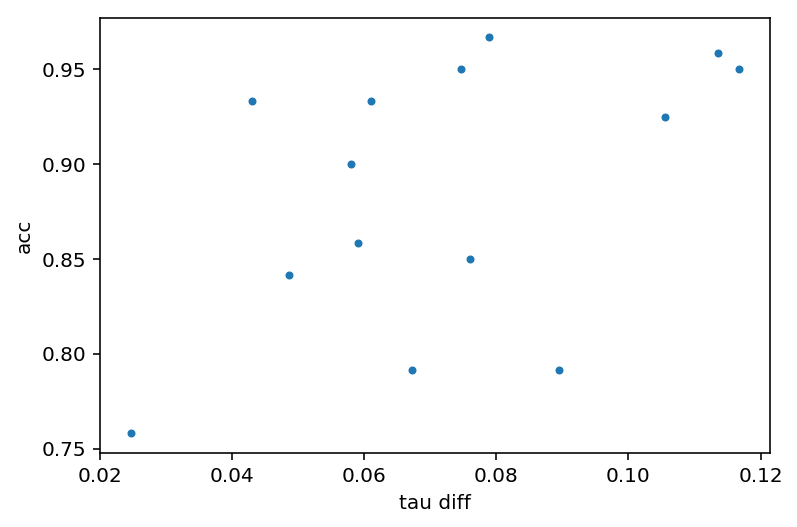

In [386]:
log_tau = True

grand_avg = []
valid_pat = np.unique(df_alltrials['patient'])

# collect all patients
for i_p in valid_pat:
    df_p = df_alltrials[(df_alltrials['patient']==i_p)]

    # pre-stim epoch
    df_pre = df_p[df_p['cond']==0] 

    # get avg values for encoding epoch
    arr_enc = (df_p[df_p['cond']==1].values + df_p[df_p['cond']==2].values)/2
    df_enc = pd.DataFrame(arr_enc, columns=col_names, index=df_pre.index) 

    # compute t-diff and channel average across trials
    t_collect = []
    n_nans = 0
    for g, g_df in df_pre.groupby('trial'):
        # print(g, end='|')
        t_pre = df_pre.loc[g_df.index]['tau']
        t_enc = df_enc.loc[g_df.index]['tau']
        if log_tau:
            t_diff = np.log10(t_enc) - np.log10(t_pre)
        else:
            t_diff = t_enc - t_pre

        t_collect.append([np.nanmean(t_pre), np.nanmean(t_enc), np.nanmean(t_diff)])
        n_nans += np.isnan(t_diff).sum()

    t_collect = np.array(t_collect)
    # t-test on tau diff
    tval, pval = ttest_1samp(t_collect[:,-1],0, nan_policy='omit')
    data_qual = (1-n_nans/len(df_pre))*100
    i_p, data_qual, len(df_pre), tval, pval

    grand_avg.append(np.concatenate(([data_qual], np.nanmean(t_collect, 0), [tval])))

# run stats
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index.values[patient_inds], 
                         columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])


df_patient = pd.concat((df_patient_info.loc[df_result.index], df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

plt.plot(df_patient['diff'],df_patient['acc'], '.')
plt.xlabel('tau diff');plt.ylabel('acc');
# print(spearmanr(df_patient['diff'], df_patient['acc'], nan_policy='omit'))
# print(pearsonr(df_patient['diff'], df_patient['acc']))
# df_patient

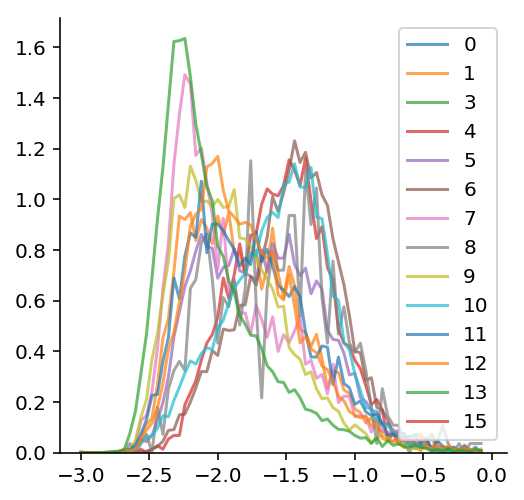

In [367]:
bins = np.arange(-3,0,0.04)
plt.figure(figsize=(4,4))
for i_p in patient_inds:
    counts = np.histogram(np.log10(df_alltrials[df_alltrials['patient']==i_p]['tau']), bins, density=True)[0]
    plt.plot(bins[:-1],counts, alpha=0.7)
    
plt.legend(patient_inds)
plt.hist(np.log10(df_alltrials[df_alltrials['patient']==i_p]['tau']), bins, histtype='step', ec='k',lw=2, density=True);
despine();

### per-subject outlier

Ttest_1sampResult(statistic=3.5112689632775904, pvalue=0.003830386814103936)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     7.943
Date:                Mon, 09 Dec 2019   Prob (F-statistic):            0.00733
Time:                        23:43:44   Log-Likelihood:                 24.079
No. Observations:                  14   AIC:                            -42.16
Df Residuals:                      11   BIC:                            -40.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


,age,sex,acc_identity,acc_spatial,acc_temporal,rt_identity,rt_spatial,rt_temporal,sampling_rate,data_qual,pre,enc,diff,tvals,acc,rt
patient,,,,,,,,,,,,,,,,
s1,33.0,F,0.900,0.950,0.850,1947.968750,1844.540541,1556.852941,1000,63.063063,-1.758012,-1.693033,0.060415,2.638133,0.900000,1783.120744
s2,50.0,M,0.950,0.975,0.975,1155.111111,1092.236842,1169.378378,1000,44.690265,-1.741806,-1.654086,0.085683,4.219046,0.966667,1138.908777
s4,31.0,M,0.925,0.925,0.950,1562.411765,1740.277778,2069.567568,1000,38.317191,-1.510880,-1.516920,0.005174,0.311346,0.933333,1790.752370
s5,22.0,M,0.825,0.800,0.750,3174.531250,2535.322581,3142.178571,1000,42.467949,-1.655742,-1.561749,0.085814,4.243014,0.791667,2950.677467
s6,31.0,M,0.925,1.000,0.925,1685.702703,962.925000,1088.351351,1000,25.748621,-1.449716,-1.423640,0.057249,3.741411,0.950000,1245.659685
s7,34.0,M,0.900,1.000,0.975,779.371429,740.131579,647.594595,1000,48.863636,-1.885424,-1.770195,0.118837,6.647390,0.958333,722.365867
s8,27.0,M,0.900,0.975,0.975,1469.166667,1037.076923,989.282051,512,25.555556,-1.564917,-1.465700,0.133147,1.859602,0.950000,1165.175214
s9,34.0,F,0.875,0.825,0.825,1700.057143,1308.848485,1797.484848,512,70.909091,-1.878966,-1.881546,-0.003136,-0.262169,0.841667,1602.130159
s10,42.0,M,0.875,0.975,0.925,869.800000,661.297297,811.352941,1000,42.626559,-1.567420,-1.483513,0.092651,5.495995,0.925000,780.816746


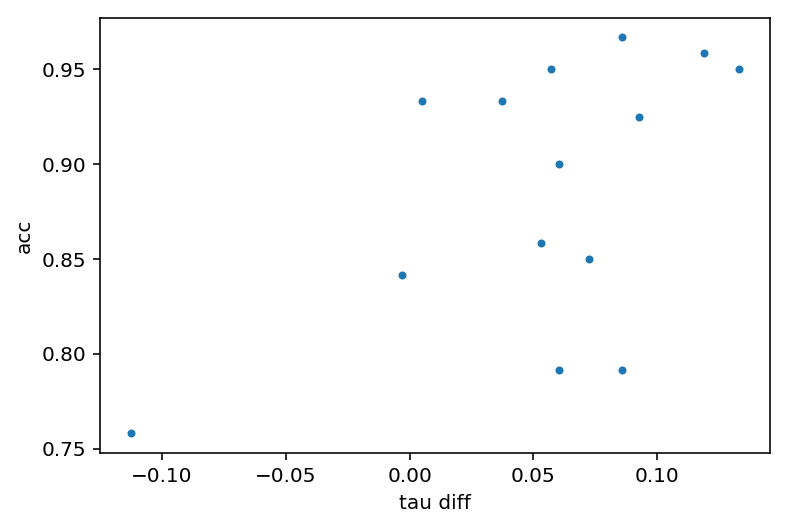

In [387]:
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

grand_avg = []

for i_p in range(len(df_patient_info)):
    # remove bad fits if exp<0 or knee<0
    feature[i_p][(all_exp[i_p]<0) | (all_knee[i_p]<=0)] = np.nan
    #feature[i_p][(all_tau[i_p]<0)| (all_tau[i_p]>0.5)] = np.nan
    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    outliers = 4
    encoding = np.log10(encoding)
    z_encoding = np.abs((encoding - np.nanmean(encoding)/np.nanstd(encoding)))
    encoding[z_encoding >= outliers] = np.nan
    prestim = np.log10(prestim)
    z_prestim = np.abs((prestim - np.nanmean(prestim)/np.nanstd(prestim)))
    prestim[z_prestim >= outliers] = np.nan
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    
    # collect results
    grand_avg.append([(1-np.isnan(d_enc_pre).sum()/np.prod(d_enc_pre.shape))*100, 
                      np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])

df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[patient_inds].values 
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

plt.plot(df_patient['diff'],df_patient['acc'], '.')
plt.xlabel('tau diff');plt.ylabel('acc');
#plt.xlim([0, 0.01])
print(spearmanr(df_patient['diff'], df_patient['acc'], nan_policy='omit'))
#print(pearsonr(df_patient['diff'], df_patient['acc']))
df_patient

# Reproducing using Brad's fits

In [183]:
# load data
with open("../notebooks/Johnson/all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
# with open("../notebooks/Johnson/all_offset.txt", "rb") as fp: # unpickling
#     all_offset = pickle.load(fp)
with open("../notebooks/Johnson/all_kfq.txt", "rb") as fp: # unpickling
    all_kfreq = pickle.load(fp)
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)
    
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

t_vals, p_vals = [], []
grand_avg = []
for i_p in range(len(df_patient_info)-1):    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    grand_avg.append([np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])
    t_vals.append(tval)
    p_vals.append(pv)

#df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['pre', 'enc', 'diff', 'tvals'])
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], columns=['pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values # s3 has really bad data, s15 & s17 are same as s5 & s8
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)
df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())


Ttest_1sampResult(statistic=4.64264145422118, pvalue=0.00046062259763812654)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     9.807
Date:                Thu, 28 Nov 2019   Prob (F-statistic):            0.00359
Time:                        16:34:15   Log-Likelihood:                 24.988
No. Observations:                  14   AIC:                            -43.98
Df Residuals:                      11   BIC:                            -42.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is n

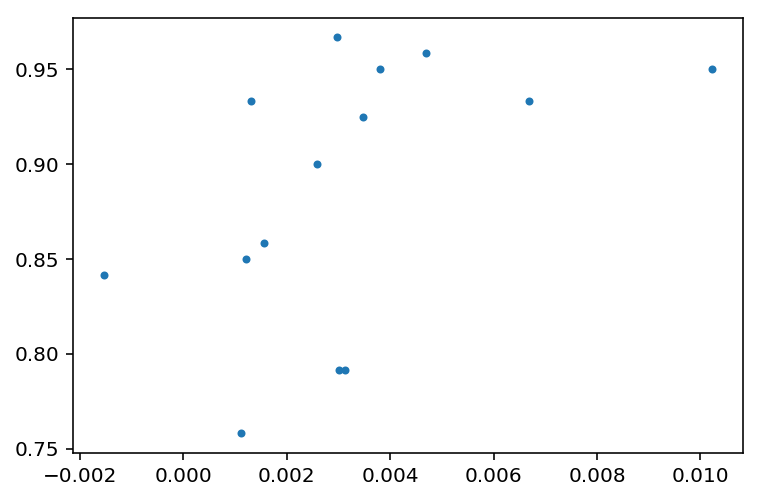

In [185]:
plt.plot(df_patient['diff'],df_patient['acc'], '.')

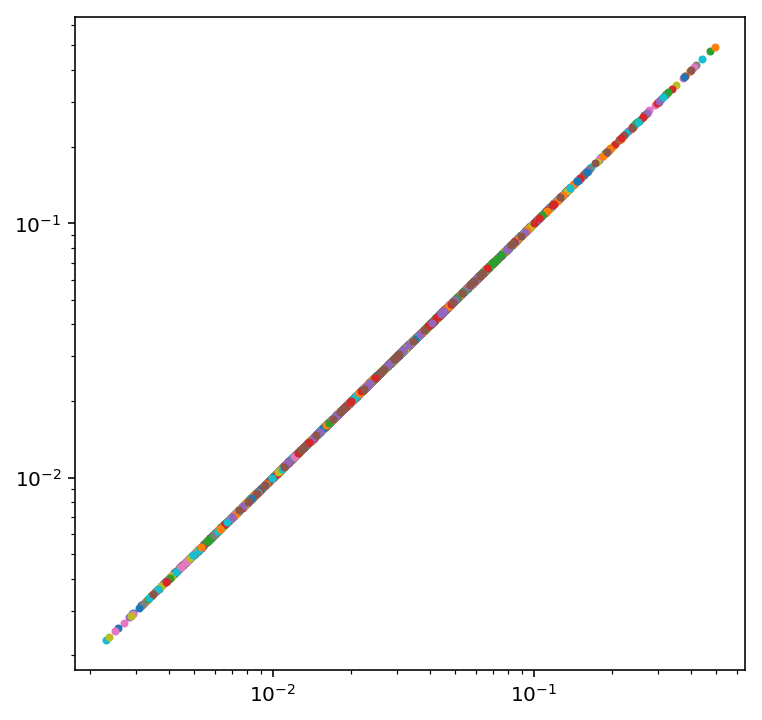

In [191]:
#bv_all_tau = all_tau
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    bv_all_tau = pickle.load(fp)

plt.figure(figsize=(6,6))
cond=0
subj=-8
plt.plot(bv_all_tau[subj][cond], all_tau[subj][cond], '.');
#df_patient.index[-8]

In [194]:
all_tau

[array([[[       nan, 0.01062263, 0.01118819, ..., 0.00658618,
          0.00657521, 0.02446878],
         [0.00666273, 0.01892358, 0.00488353, ..., 0.04222276,
          0.00754101, 0.01624006],
         [0.00838021,        nan, 0.00544218, ..., 0.04481602,
          0.01007631, 0.01379476],
         ...,
         [0.01663331, 0.02048147, 0.00441489, ..., 0.00557668,
          0.00703279, 0.02290868],
         [0.01815044, 0.02212425, 0.03181135, ..., 0.02640274,
          0.07293245, 0.02491022],
         [0.02558703, 0.01543443, 0.00743301, ..., 0.02234141,
          0.01943496, 0.00851247]],
 
        [[0.00363532, 0.01110497, 0.01306794, ..., 2.18462338,
          0.00575535, 0.00500063],
         [0.05757515, 0.00605693,        nan, ..., 0.00905366,
          0.00574139, 0.01251635],
         [       nan, 0.01752722, 0.1540081 , ..., 0.03030747,
          0.03196186, 0.09033974],
         ...,
         [0.00412968, 0.00596408, 0.01314917, ..., 0.01559453,
                 nan, 0.

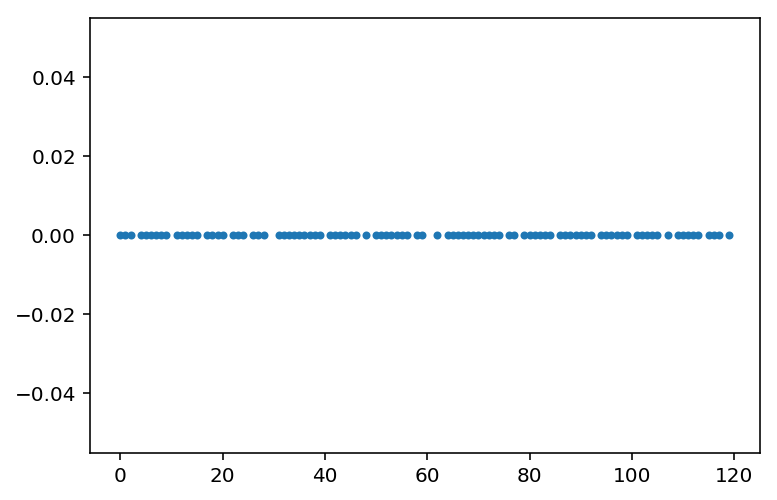

In [193]:
subj, cond, chan = -4, 1, 2
#plt.loglog(bv_all_tau[-2][cond,chan], all_tau[-2][cond,chan], '.')
#plt.plot(plt.xlim(),plt.ylim(), '--')
plt.plot(bv_all_tau[subj][cond,chan]-all_tau[subj][cond,chan], '.')